In [1]:
import librosa
import librosa.display
import pandas as pd
import IPython.display as ipd
import os
import matplotlib.pyplot as plt #to display the signals of the audio files
%matplotlib inline
from matplotlib.pyplot import specgram
import numpy as np
import tqdm
from tqdm.notebook import tqdm_notebook
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns

from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.utils import shuffle
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Activation, Dropout
from tensorflow.keras.layers import BatchNormalization, InputLayer
from tensorflow.keras.layers import Flatten, Dense, LSTM, GRU
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.backend import clear_session
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
audio = r"C:\Users\letym\Desktop\datasets\audio"
metadata = pd.read_csv(r"C:\Users\letym\Desktop\datasets\UrbanSound8K.csv")

In [3]:
metadata.head(10)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
5,100263-2-0-143.wav,100263,71.500000,75.500000,1,5,2,children_playing
6,100263-2-0-161.wav,100263,80.500000,84.500000,1,5,2,children_playing
7,100263-2-0-3.wav,100263,1.500000,5.500000,1,5,2,children_playing
8,100263-2-0-36.wav,100263,18.000000,22.000000,1,5,2,children_playing
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn


In [4]:
#check whether the dataset is balanced
metadata['class'].value_counts()

jackhammer          1000
children_playing    1000
drilling            1000
engine_idling       1000
air_conditioner     1000
dog_bark            1000
street_music        1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

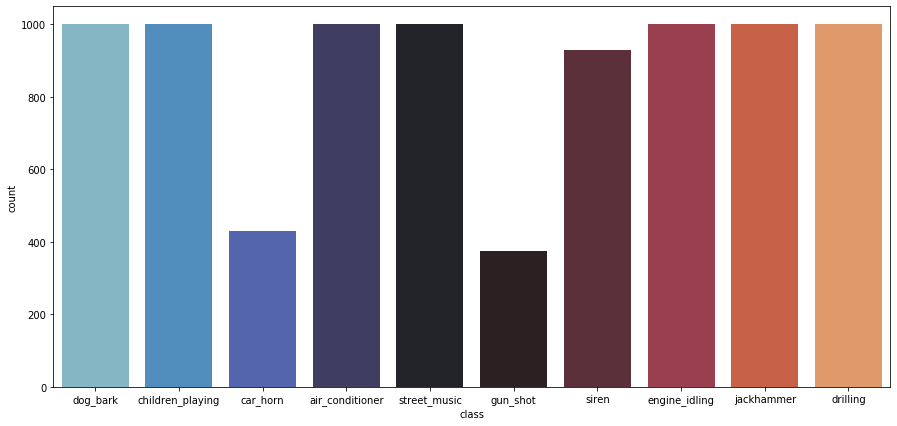

In [5]:
#graphical representation of the balance of the classes
plt.figure(figsize=(15,7))
sns.countplot(metadata['class'], palette = 'icefire')

In [6]:
#DATA PREPROCESSING: FEATURE EXTRACTION #MELSPECTROGRAMS
melspectrogram_features = []
for index, row in metadata.iterrows():
    file_name = os.path.join(os.path.abspath(r"C:\Users\letym\Desktop\datasets\audio"),'fold'+str(row["fold"])+'/', str(row["slice_file_name"]))
    final_class_labels=row["class"]
    fold=row["fold"]
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    normalized_audio = librosa.util.normalize(audio)
    mels = librosa.feature.melspectrogram(y=audio, sr = sample_rate, n_mels=50)
    mel_db = librosa.amplitude_to_db(abs(mels))
    
    melspectrogram_features.append([mel_db, fold, final_class_labels])

C:\Users\letym\anaconda3\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1323
  n_fft, y.shape[-1]
C:\Users\letym\anaconda3\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1103
  n_fft, y.shape[-1]
C:\Users\letym\anaconda3\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1523
  n_fft, y.shape[-1]


In [7]:
melspectrogram_features

[[array([[-35.672268  , -35.672268  , -35.672268  , -35.672268  ,
          -35.672268  , -35.672268  , -35.672268  , -35.672268  ,
          -35.672268  , -35.672268  , -35.672268  , -35.672268  ,
          -35.672268  , -35.672268  ],
         [-35.672268  , -35.672268  , -35.672268  , -35.672268  ,
          -35.672268  , -35.672268  , -35.672268  , -35.672268  ,
          -35.672268  , -35.672268  , -35.672268  , -35.672268  ,
          -35.672268  , -35.672268  ],
         [-35.672268  , -35.672268  , -35.672268  , -35.672268  ,
          -35.672268  , -35.672268  , -35.672268  , -35.672268  ,
          -35.672268  , -35.672268  , -35.672268  , -35.672268  ,
          -35.672268  , -35.672268  ],
         [-35.672268  , -35.672268  , -35.672268  , -35.672268  ,
          -35.672268  , -35.672268  , -35.672268  , -35.672268  ,
          -35.672268  , -35.672268  , -35.672268  , -35.672268  ,
          -35.672268  , -35.672268  ],
         [-35.672268  , -35.672268  , -35.672268  , 

In [8]:
#converting extracted features to a dataframe
melspectrogram_features_df = pd.DataFrame(melspectrogram_features, columns=['mels', 'fold', 'class'])
melspectrogram_features_df.head()

,mels,fold,class
0,"[[-35.672268, -35.672268, -35.672268, -35.6722...",5,dog_bark
1,"[[-34.584854, -29.407557, -32.772266, -30.8399...",5,children_playing
2,"[[-32.47324, -25.805052, -25.7187, -33.848335,...",5,children_playing
3,"[[-22.059559, -27.40448, -33.831467, -32.49224...",5,children_playing
4,"[[-27.562609, -26.490133, -27.8117, -30.95269,...",5,children_playing


In [9]:
melspectrogram_features_df.to_csv('melspectrogram_features_df.csv')

In [10]:
#definition of train and test folds
train_fold = [1, 2, 3, 4, 6]
test_fold = [5, 7, 8, 9, 10]

In [11]:
train_data = melspectrogram_features_df.loc[melspectrogram_features_df['fold'].isin(train_fold)]
test_data = melspectrogram_features_df.loc[melspectrogram_features_df['fold'].isin(test_fold)]

In [12]:
train_data.shape

(4499, 3)

In [13]:
test_data.shape

(4233, 3)

In [14]:
def add_padding(features, max_len):
    X = [pad_sequences(x, maxlen = max_len, padding="post", truncating= "post") for x in features]
    #X_norm = [StandardScaler().fit_transform(x) for x in X]
    return np.array(X)

In [15]:
train_data['mels']

14      [[-33.164352, -33.164352, -31.84373, -30.46107...
15      [[-32.8454, -32.8454, -32.8454, -32.8454, -32....
16      [[-26.35453, -26.35453, -26.35453, -26.35453, ...
17      [[-22.616634, -22.616634, -22.616634, -22.6166...
53      [[-51.830437, -51.830437, -51.830437, -51.8304...
                              ...                        
8718    [[-4.5265636, 3.976274, 7.671263, 5.6844225, 0...
8719    [[-0.13643613, -2.0970523, -1.8447423, -6.0166...
8720    [[4.241396, -6.1918793, -16.994884, -9.65973, ...
8721    [[-4.8149986, -6.1933804, -7.9640074, -9.19000...
8722    [[8.2781725, 7.099141, 5.9512234, 3.7105408, 6...
Name: mels, Length: 4499, dtype: object

In [16]:
encoder = LabelEncoder()
X_train = add_padding(train_data['mels'], 174)
y_train = to_categorical(encoder.fit_transform(train_data['class']))
X_test = add_padding(test_data['mels'], 174)
y_test = to_categorical(encoder.fit_transform(test_data['class']))

In [17]:
X_train.shape

(4499, 50, 174)

In [18]:
X_test.shape

(4233, 50, 174)

In [19]:
X_train = X_train.reshape(X_train.shape[0], 50, 174, 1)
X_test = X_test.reshape(X_test.shape[0], 50, 174, 1)

In [20]:
X_train.shape

(4499, 50, 174, 1)

In [21]:
X_test.shape

(4233, 50, 174, 1)

In [22]:
y_train.shape

(4499, 10)

In [23]:
y_test.shape

(4233, 10)

In [24]:
def testfold_pred(model, feature):
    e = LabelEncoder()
    acc = []
    for f in test_fold:
        fold = melspectrogram_features_df.loc[melspectrogram_features_df['fold'] == f]
        if feature == "mels":
            y_pred = model.predict(X_test.reshape(X_test.shape[0], 50, 174))
        elif feature == "cnn_mels":
            y_pred = model.predict(X_test)
        elif feature == "fnn_mels":
            y_pred = model.predict(X_test)
        elif feature == "lenet_mels":
            y_pred = model.predict(X_test)
        y_hat = []
        y_true = []
        for i in range(len(y_pred)):
            y_hat.append(np.argmax(y_pred[i]))
            y_true.append(np.argmax(y_test[i]))

        a = accuracy_score(y_true, y_hat)
        acc.append(a)
    std = np.std(acc)
    mean = np.mean(acc)
    return mean, std, acc

In [25]:
#LeNet-5

lenet_mels = Sequential()
lenet_mels.add(Conv2D(32, (3, 3), activation = "tanh", strides=(1, 1), input_shape = (50, 174, 1), padding = "same"))

lenet_mels.add(MaxPooling2D(2, 2))
lenet_mels.add(Conv2D(32, (3, 3), strides=(1, 1),  activation = "tanh", padding = 'valid'))

lenet_mels.add(MaxPooling2D(2, 2))
lenet_mels.add(Conv2D(64, (3, 3), strides=(1, 1),  activation = "tanh", padding = 'valid'))
lenet_mels.add(MaxPooling2D(2, 2))
lenet_mels.add(Flatten())
lenet_mels.add(Dense(512, activation = "tanh"))
lenet_mels.add(Dropout(0.5))
lenet_mels.add(Dense(10, activation = "softmax"))

In [26]:
lenet_mels.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 174, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 87, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 85, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 42, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 40, 64)         18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 20, 64)        0

In [27]:
lenet_mels.compile(loss = "categorical_crossentropy", optimizer = Adam(1e-3), metrics = "accuracy")
lenet_mels_result = lenet_mels.fit(X_train, y_train, epochs = 50, batch_size = 24, validation_split = 0.2)

Epoch 1/50
150/150 [==============================] - 107s 692ms/step - loss: 1.7557 - accuracy: 0.4790 - val_loss: 2.1153 - val_accuracy: 0.4156
Epoch 2/50
150/150 [==============================] - 98s 656ms/step - loss: 0.8363 - accuracy: 0.7288 - val_loss: 2.1572 - val_accuracy: 0.4367
Epoch 3/50
150/150 [==============================] - 99s 663ms/step - loss: 0.5107 - accuracy: 0.8313 - val_loss: 2.3371 - val_accuracy: 0.4133
Epoch 4/50
150/150 [==============================] - 107s 716ms/step - loss: 0.3390 - accuracy: 0.8827 - val_loss: 2.8119 - val_accuracy: 0.3811
Epoch 5/50
150/150 [==============================] - 115s 767ms/step - loss: 0.1927 - accuracy: 0.9444 - val_loss: 2.5848 - val_accuracy: 0.4256
Epoch 6/50
150/150 [==============================] - 103s 684ms/step - loss: 0.1559 - accuracy: 0.9483 - val_loss: 3.4681 - val_accuracy: 0.3267
Epoch 7/50
150/150 [==============================] - 108s 721ms/step - loss: 0.1371 - accuracy: 0.9586 - val_loss: 2.8191 - v

In [28]:
mean, std, acc = testfold_pred(lenet_mels, feature = 'lenet_mels')

In [29]:
mean, std, acc

(0.48216394991731637,
 5.551115123125783e-17,
 [0.4821639499173163,
  0.4821639499173163,
  0.4821639499173163,
  0.4821639499173163,
  0.4821639499173163])

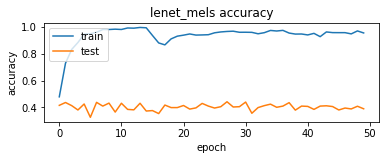

In [30]:
plt.subplot(211)  
plt.plot(lenet_mels_result.history['accuracy'])
plt.plot(lenet_mels_result.history['val_accuracy'])  
plt.title('lenet_mels accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left') 

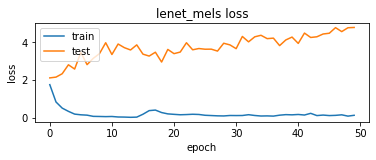

In [31]:
plt.subplot(212)  
plt.plot(lenet_mels_result.history['loss'])  
plt.plot(lenet_mels_result.history['val_loss'])  
plt.title('lenet_mels loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()